In [1]:
import pandas as pd
import numpy as np
import os
from os.path import exists
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
sns.set_theme(style="dark")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import sys
sys.path.append('..')
from laos_gggi import load_all_data, load_wb_data, load_ocean_heat_data
from laos_gggi.statistics import ADF_test_summary

In [2]:
data_dict = load_all_data()
df_ocean = data_dict['ocean_temperature']
df_co2 = data_dict['co2']

In [3]:
df_ocean.index.freq = df_ocean.index.inferred_freq
df_co2.index.freq = df_co2.index.inferred_freq

## Ocean Heat

First we are converting from quarterly to annual data.

<Axes: xlabel='year'>

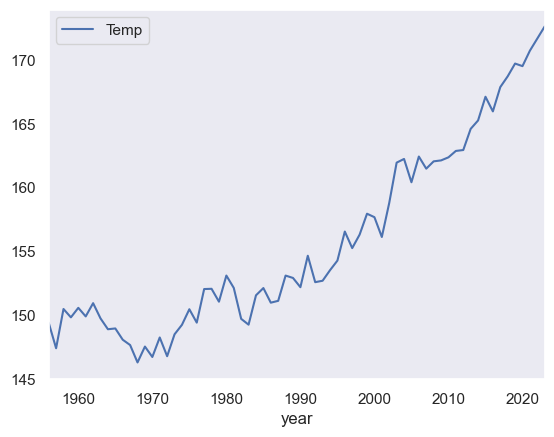

In [4]:
df_ocean.plot()

Like our reference paper, we will be taking the mean ocean temperature from 1970 to 2000 as our base period.

In [5]:
print(df_ocean.loc['1970-01-01':'1999-01-01'].mean())

Temp    151.870457
dtype: float64


In [6]:
df_oceanb = df_ocean - df_ocean.loc['1970-01-01':'1999-01-01'].mean()

In [7]:
df_oceanb_diff = df_oceanb['Temp'].diff().dropna()

<Axes: xlabel='year'>

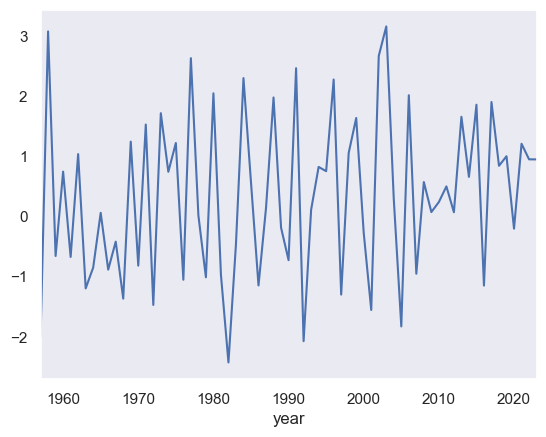

In [8]:
df_oceanb_diff.plot()

Taking first differences, we find that our result is stationary with a frend specification. This suggests exponential growth in the level series, which is consistent with the first plot we made.

In [9]:
ADF_test_summary(df_oceanb_diff)

                                                     Temp                                                     
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -1.619         -8.314        0.000          1    -4.105      -3.480     -3.168
	Constant            -0.227         -0.747        0.458
	Trend                0.024          2.855        0.006
Constant Only               -1.454         -7.404        0.000          1    -3.535      -2.907     -2.591
	Constant             0.504          2.916        0.005
No Constant                 -1.209        -10.089        0.000          0    -2.600      -1.946     -1.613


There is however one significant autocorrelation lag.

In [10]:
import statsmodels.api as sm
import warnings
# Fit ARIMA model (0, 2, 1) - 1 AR terms, differencing order 2, and 0 MA terms
model = ARIMA(df_oceanb, order=(1, 1, 2))
model_fit = model.fit()


In [11]:
# Step 5: Forecasting
forecast_steps = 10  # Number of future years to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Forecast index for plotting
forecast_index = pd.date_range(start=df_oceanb.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YS')

# Get the fitted values from the model (in-sample predictions)
fitted_values = model_fit.fittedvalues

We can see that our SARIMAX model fits the data well, the first year is when there is not enough data to do first order differencing so the model is incomplete. Additionally, we have predicted the next 10 years of data. These are linear because the most recent decade has been linear.

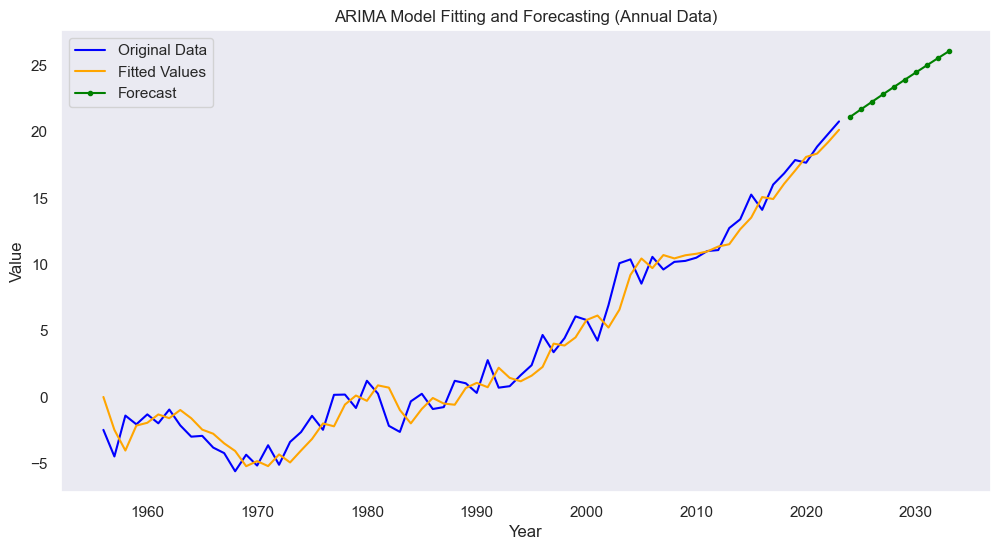

In [12]:
# Plot original data, fitted values, and forecast
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_oceanb, label='Original Data', color='blue')
ax.plot(df_oceanb.index, fitted_values, label='Fitted Values', color='orange')
ax.plot(forecast_index, forecast, label='Forecast', color='green', marker='.')
ax.set(title='ARIMA Model Fitting and Forecasting (Annual Data)',
       xlabel='Year', ylabel='Value')
ax.legend()
plt.show()

Despite the run in the late 60s, there does not appear to be a problem with autocorrelation in residuals.

Looking at the residuals of our model, we see that the residuals follow a roughly normal distribution symmetrical about zero.

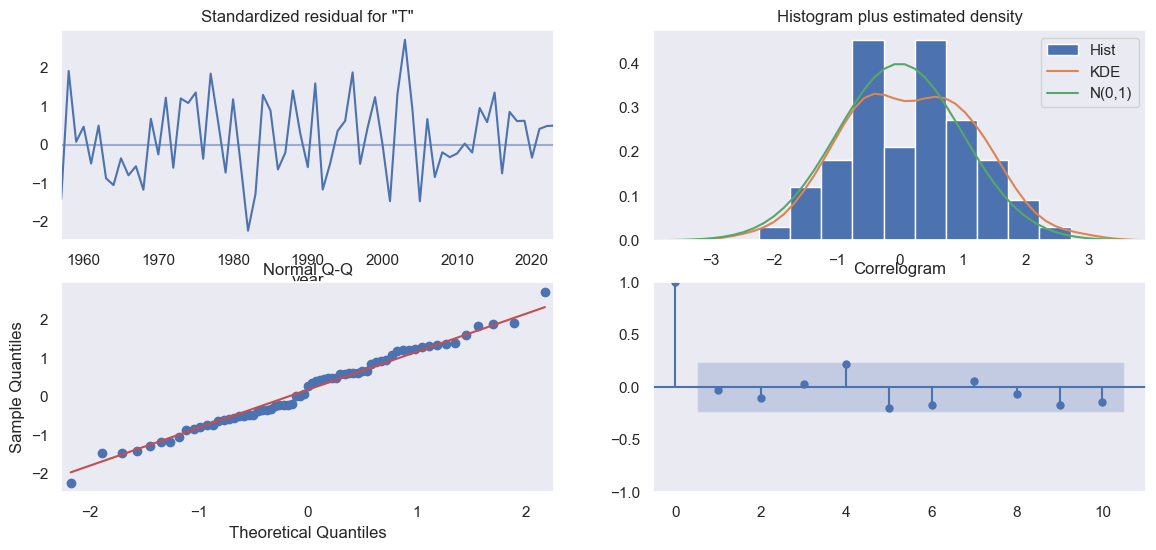

In [13]:
model_fit.plot_diagnostics(figsize=(14, 6));

## CO2

<Axes: xlabel='year'>

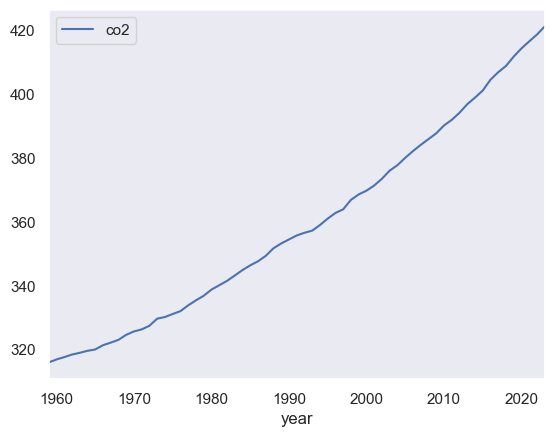

In [14]:
df_co2.plot()

<Axes: xlabel='year'>

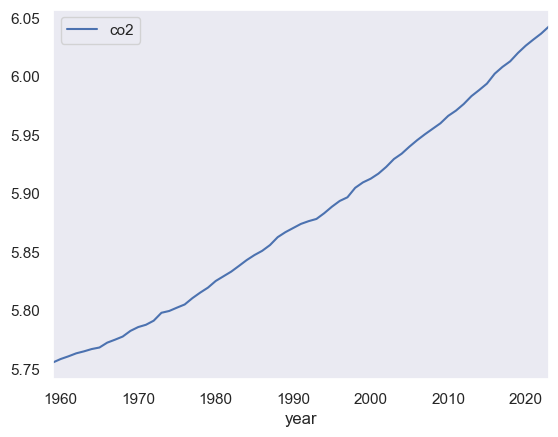

In [15]:
np.log(df_co2).plot()

In the paper they are taking the difference from 1970, since our dataset starts in 1979 we are taking the mean of the first five years of our sample.

In [16]:
df_co2.loc['1979-01-01':'1983-01-01'].mean()

co2    340.07
dtype: float64

In [17]:
df_co2b = df_co2 - df_co2.loc['1979-01-01':'1983-01-01'].mean()

<Axes: xlabel='year'>

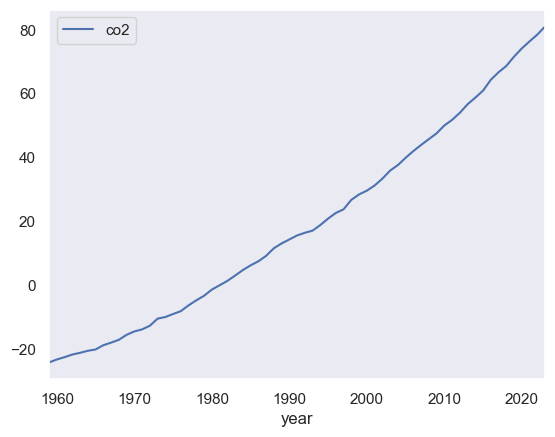

In [18]:
df_co2b.plot()

Next, let's look at annual change.

In [19]:
df_co2b_diff = df_co2b.diff().dropna()

We can see that it is not stationary, the rate of increase in $CO_2$ concentration has increased. Counter to our original graph, we now see that $CO_2$ is now linear.

<Axes: xlabel='year'>

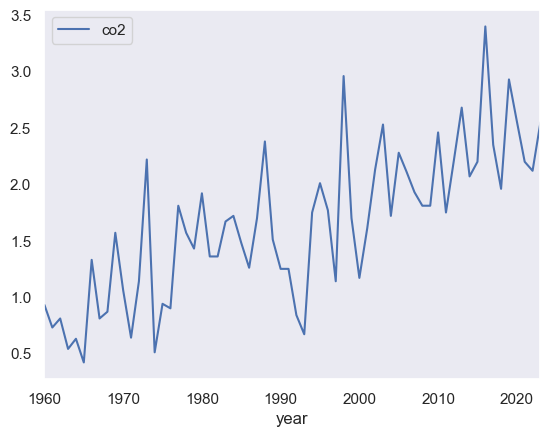

In [20]:
df_co2b_diff.plot()

There is a high degree of autocorrelation. Note the first 4 lags are all positively correlated.

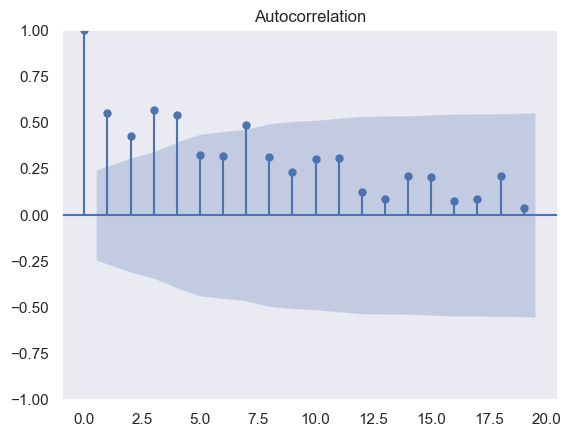

In [21]:
plot_acf(df_co2b_diff['co2'])
plt.show()

In [22]:
df_co2b_diff2 = df_co2b_diff.diff().dropna()

Taking second differences, we have achieved stationarity. This suggests a quadratic equation to fit our original data.

<Axes: xlabel='year'>

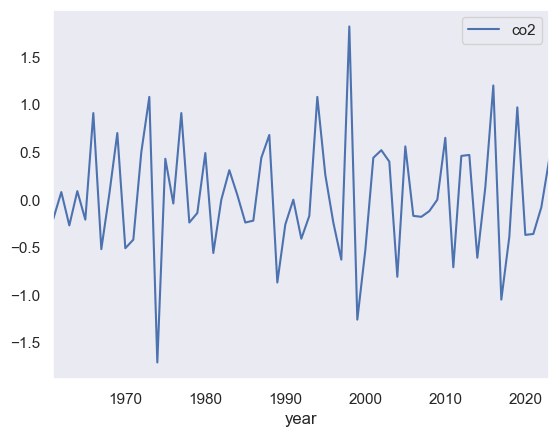

In [23]:
df_co2b_diff2.plot()

In [24]:
ADF_test_summary(df_co2b_diff2)

                                                     co2                                                      
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -2.826         -8.815        0.000          2    -4.118      -3.486     -3.171
	Constant             0.114          0.888        0.379
	Trend               -0.001         -0.331        0.742
Constant Only               -2.824         -8.880        0.000          2    -3.544      -2.911     -2.593
	Constant             0.077          1.220        0.228
No Constant                 -2.776         -8.760        0.000          2    -2.604      -1.946     -1.613


We still see an autocorrelation effect with a reverse in sign in the first lag. For modeling out data we will use an ARIMA equation with one lag.

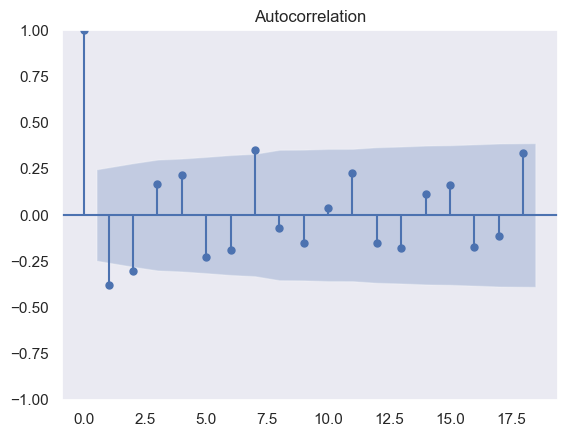

In [25]:
plot_acf(df_co2b_diff2['co2'])
plt.show()

In [26]:
# Fit ARIMA model (0, 2, 1) - 1 AR terms, differencing order 2, and 0 MA terms
model = ARIMA(df_co2b, order=(1, 2, 0))
model_fit = model.fit()

In [27]:
# Print the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                   65
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 -54.803
Date:                Fri, 26 Jul 2024   AIC                            113.606
Time:                        12:58:08   BIC                            117.892
Sample:                    01-01-1959   HQIC                           115.292
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3735      0.109     -3.429      0.001      -0.587      -0.160
sigma2         0.3327      0.059      5.613      0.000       0.217       0.449
Ljung-Box (L1) (Q):                   2.72   Jarque-

In [28]:
# Step 5: Forecasting
forecast_steps = 10  # Number of future years to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Forecast index for plotting
forecast_index = pd.date_range(start=df_co2b.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YS')

# Get the fitted values from the model (in-sample predictions)
fitted_values = model_fit.fittedvalues

We can see that our SARIMAX model fits the data well, the first two years are when there is not enough data to do second order differencing so the model is incomplete. Additionally, we have predicted the next 10 years of data. These are linear (despite the previous data being quadratic) because the most recent several years have been linear. This continues the trend from the last five years.

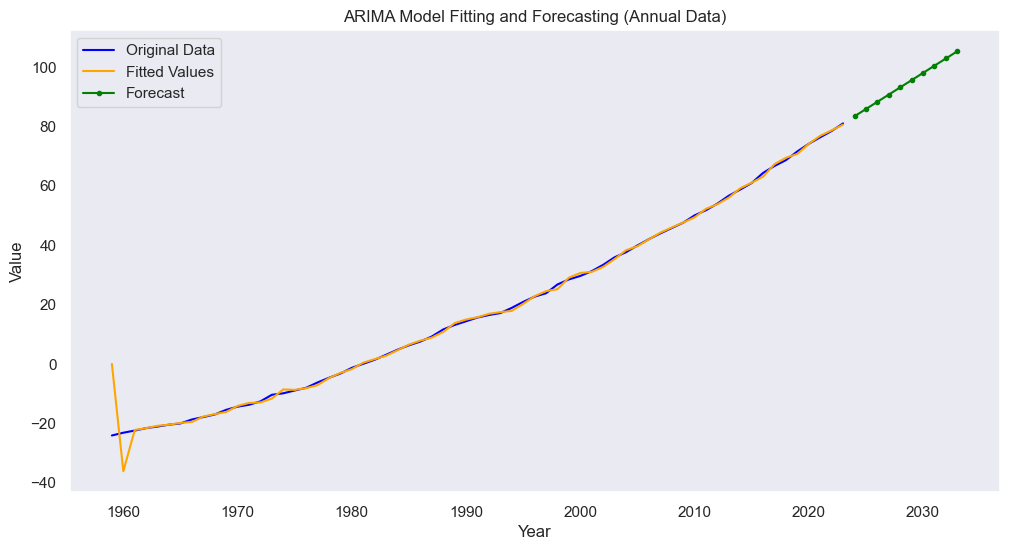

In [29]:
# Plot original data, fitted values, and forecast
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_co2b, label='Original Data', color='blue')
ax.plot(df_co2b.index, fitted_values, label='Fitted Values', color='orange')
ax.plot(forecast_index, forecast, label='Forecast', color='green', marker='.')
ax.set(title='ARIMA Model Fitting and Forecasting (Annual Data)',
      xlabel='Year',
      ylabel='Value')
ax.legend()
plt.show()

Plotting the residuals of our model (excluding the first two years), we see that it is often very accurate to predicting the following year's $co_2$ level, however the remaining residuals are quite distributed. Notably, all of our predicted values are with +-1 PPM of the actual PPM concentration.

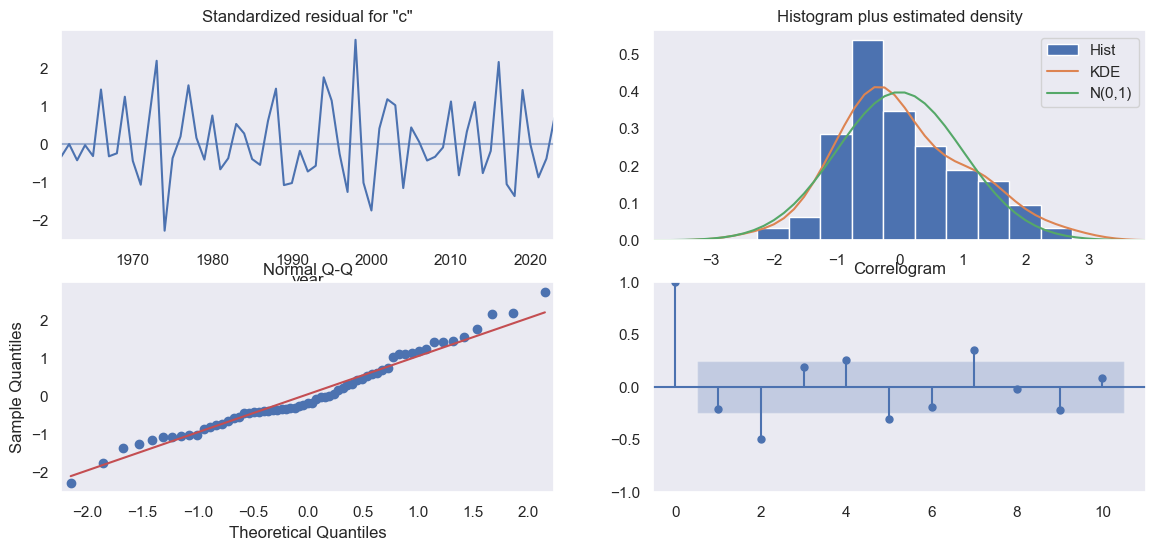

In [30]:
model_fit.plot_diagnostics(figsize=(14,6));

## Both together

<Axes: xlabel='year'>

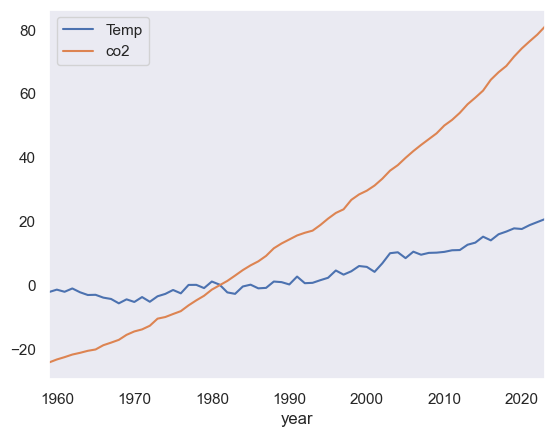

In [31]:
merged_df = df_oceanb.join(df_co2b).dropna()
merged_df.plot()

There is not an interesting relationship between the two because both are increasing over time:

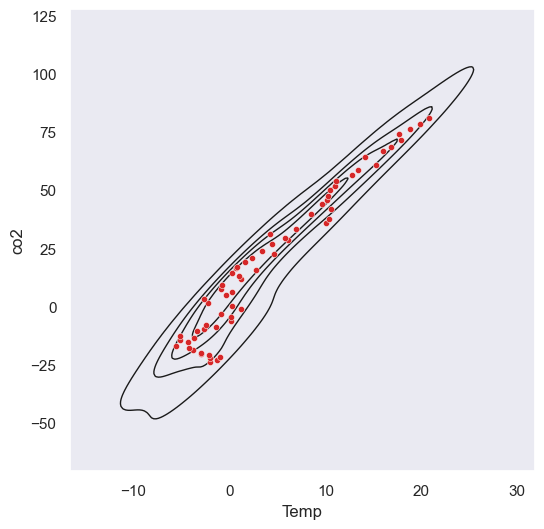

In [32]:
x = merged_df['Temp']
y = merged_df['co2']

# Draw a combo histogram and scatterplot with density contours
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=20, color="tab:red", zorder=100, ax=ax)
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako", ax=ax)
sns.kdeplot(x=x, y=y, levels=5, color="k", linewidths=1, ax=ax)
plt.show()

Additionally, when taking first differences again we do not see a relationship:

In [33]:
merged_df['Temp_diff'] = merged_df['Temp'].diff()
merged_df['co2_diff'] = merged_df['co2'].diff()

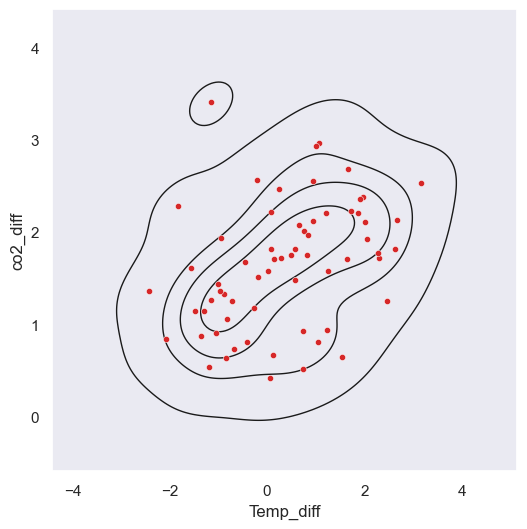

In [34]:
x = merged_df['Temp_diff']
y = merged_df['co2_diff']

# Draw a combo histogram and scatterplot with density contours
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=20, color="tab:red", zorder=100, ax=ax)
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako", ax=ax)
sns.kdeplot(x=x, y=y, levels=5, color="k", linewidths=1, ax=ax)
plt.show()